## Import library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

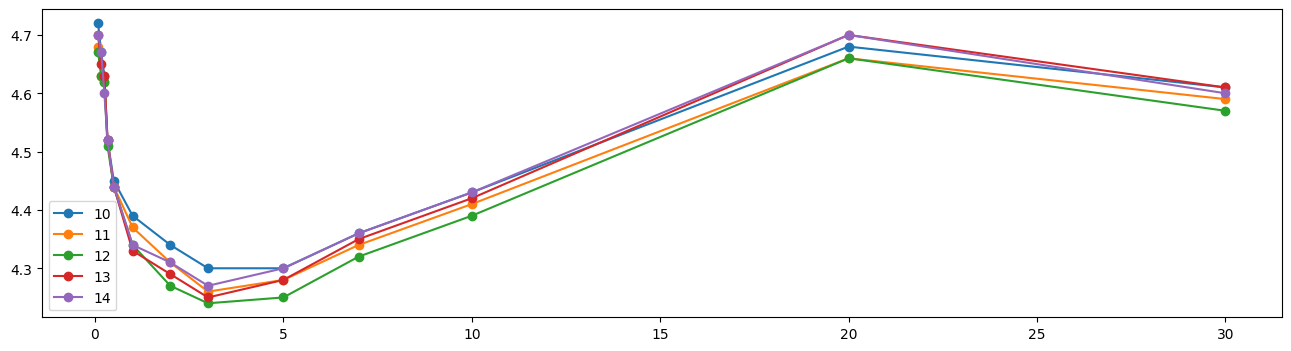

In [2]:
def treasury_data_retrieval():
    df = pd.read_csv('../data/us_treasury_rates.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values(by='Date', ascending=False, inplace=True)

    return df

id_list = range(10, 15)
df = treasury_data_retrieval()
header = [1/12, 2/12, 3/12, 4/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30]

plt.figure(figsize=(16, 4))
for id in range(10, 15):
    row = df.iloc[id, 1:].values
    plt.plot(header, row, marker='o')
plt.legend(id_list)

## Flatten data

In [3]:
n = len(df)
h = 5

flatten = pd.DataFrame()
for id in range(1, n):
    row = df.iloc[id:(id+h), 1:].stack().reset_index(drop=True).to_frame().T
    flatten = pd.concat([flatten, row], ignore_index=True)
flatten['y'] = df.iloc[:(n-1), 1]
flatten.dropna(inplace=True)
flatten.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,y
0,4.59,4.53,4.46,4.46,4.38,4.23,4.15,4.10,4.07,4.12,...,4.42,4.30,4.13,4.10,4.05,4.10,4.18,4.45,4.36,4.57
1,4.65,4.54,4.47,4.46,4.38,4.23,4.13,4.09,4.07,4.13,...,4.43,4.34,4.19,4.17,4.11,4.17,4.25,4.52,4.44,4.59
2,4.66,4.56,4.49,4.48,4.40,4.27,4.17,4.13,4.11,4.17,...,4.45,4.37,4.21,4.21,4.17,4.24,4.30,4.56,4.48,4.65
3,4.75,4.63,4.51,4.51,4.43,4.30,4.17,4.11,4.08,4.13,...,4.46,4.37,4.21,4.21,4.17,4.21,4.27,4.53,4.45,4.66
4,4.76,4.69,4.58,4.52,4.42,4.30,4.13,4.10,4.05,4.10,...,4.46,4.42,4.37,4.32,4.30,4.35,4.41,4.67,4.60,4.75


## Trial models

In [4]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

X, y = flatten.drop(columns='y'), flatten['y']
cv = 5

In [5]:
# Linear Regression
model = LinearRegression()
mse_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')

print("Average Mean Squared Error (MSE):", -mse_scores.mean())  # Negating the average MSE
print("Average R-squared (R²):", r2_scores.mean())


Average Mean Squared Error (MSE): 0.009081367161739988
Average R-squared (R²): -0.40905665382689416


In [13]:
# Ridge Regression
model = Ridge(alpha=0.1) 

mse_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')

print("Average Mean Squared Error (MSE):", -mse_scores.mean())  # Negating the average MSE
print("Average R-squared (R²):", r2_scores.mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

pred = model.predict(X_test)
pd.DataFrame({'pred': pred, 'real': y_test}).head(5)

Average Mean Squared Error (MSE): 0.008202188528827424
Average R-squared (R²): 0.25340841021914606


,pred,real
140,5.522253,5.49
397,5.721788,5.59
6,4.747894,4.76
334,5.555579,5.54
322,5.509915,5.54


In [13]:
# Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)

mse_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')

print("Average Mean Squared Error (MSE):", -mse_scores.mean())  # Negating the average MSE
print("Average R-squared (R²):", r2_scores.mean())


Average Mean Squared Error (MSE): 0.021235835614296098
Average R-squared (R²): 0.2654989252713829


In [5]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)

mse_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')

print("Average Mean Squared Error (MSE):", -mse_scores.mean())  # Negating the average MSE
print("Average R-squared (R²):", r2_scores.mean())


Average Mean Squared Error (MSE): 0.03365182027346703
Average R-squared (R²): -3.58451390904424


In [6]:
help(MLPRegressor)

Help on class MLPRegressor in module sklearn.neural_network._multilayer_perceptron:

class MLPRegressor(sklearn.base.RegressorMixin, BaseMultilayerPerceptron)
 |  MLPRegressor(hidden_layer_sizes=(100,), activation='relu', *, solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)
 |
 |  Multi-layer Perceptron regressor.
 |
 |  This model optimizes the squared error using LBFGS or stochastic gradient
 |  descent.
 |
 |  .. versionadded:: 0.18
 |
 |  Parameters
 |  ----------
 |  hidden_layer_sizes : array-like of shape(n_layers - 2,), default=(100,)
 |      The ith element represents the number of neurons in the ith
 |      hidden layer.
 |
 |  activation : {'identity', 'logistic'